In [34]:
import pandas as pd

# from http://nlp.cs.washington.edu/zeroshot/evaluate.py
import os
import codecs
import re
from itertools import groupby
import string
import sys
import numpy as np

PUNCTUATION = set(string.punctuation)

def eval_zero_re(test_file, answer_file):
    q_aprf = read_results(test_file, answer_file)
    return pretify(q_aprf)

def read_results(test_set, answer_file):
    with codecs.open(test_set, 'r', 'utf-8') as fin:
        data = [line.strip().split('\t') for line in fin]
    metadata = [x[:4] for x in data]
    gold = [set(x[4:]) for x in data]

    new_gold = gold  # for including unknowns.

    with codecs.open(answer_file, 'r', 'utf-8') as fin:
        answers = [line.strip() for line in fin]

    new_answers = []

    # ignore the header in answers
    for answer in answers[1:]:
        if answer != 'no_answer':
            new_answers.append(answer)
        else:
            new_answers.append("")

    telemetry = []
    for m, g, a in zip(metadata, new_gold, new_answers):
        stats = score_fn(g, a)
        telemetry.append([m[0], m[1], str(len(g) > 0), stats])
    return aprf(telemetry)


def parse_no_answers(results):
    p_answer = [a for i, a in sorted([(int(i), a) for i, a in results[0]['scores'].items()])]
    p_no_answer = [a for i, a in sorted([(int(i), a) for i, a in results[0]['na'].items()])]

    import numpy as np
    return [answer > no_answer for answer, no_answer in zip(p_answer, p_no_answer)]


def gb(collection, keyfunc):
    return [(k, list(g)) for k, g in groupby(sorted(collection, key=keyfunc), keyfunc)]


def aprf(g):
    tp, tn, sys_pos, real_pos = sum(map(lambda x: x[-1], g))
    total = len(g)
    # a = float(tp + tn) / total
    # nr = tn / float(total - real_pos)
    # npr = tn / float(total - sys_pos)
    if tp == 0:
        p = r = f = 0.0
    else:
        p = tp / float(sys_pos)
        r = tp / float(real_pos)
        f = 2 * p * r / (p + r)
    # return np.array((a, p, r, f, npr, nr))
    return np.array((p, r, f))


def score_fn(gold, answer):
    if len(gold) > 0:
        gold = set.union(*[simplify(g) for g in gold])
    answer = simplify(answer)
    result = np.zeros(4)
    if answer == gold:
        if len(gold) > 0:
            result[0] += 1
        else:
            result[1] += 1
    if len(answer) > 0:
        result[2] += 1
    if len(gold) > 0:
        result[3] += 1
    return result


def simplify(answer):
    return set(''.join(c for c in t if c not in PUNCTUATION) for t in answer.strip().lower().split()) - {'the', 'a', 'an', 'and', ''}


def pretify(results):
    return ' \t '.join([': '.join((k, v)) for k, v in zip(['Precision', 'Recall', 'F1'], map(lambda r: '{0:.2f}%'.format(r*100), results))])

In [35]:
def preprocess_the_prediction_files(main_path, list_of_files):
    for file in list_of_files:
        df = pd.read_csv(os.path.join(main_path, file), sep=',')
        df["predictions_str"].to_csv(os.path.join("/tmp/", file), sep='\t', header=True, index=False)

def eval_the_prediction_files(list_of_files, gold_file):
    scores = {}
    scores_list = []
    for file in list_of_files:
        score = eval_zero_re(gold_file, os.path.join("/tmp/", file))
        scores[score] = file
        scores_list.append(score)
    return scores, scores_list
        

In [49]:
# GOLD Predictions on the dev 1 fold 1.
fold_files = ["gold_fold_1.dev.predictions.0.step.{}.csv".format(100 * i) for i in range(0, 132, 1)]
fold_files.append("gold_fold_1.dev.predictions.0.full.csv")
fold_0_path = "~/gold_fold_1/"
fold_0_gold_file = "./zero-shot-extraction/relation_splits/dev.0"

preprocess_the_prediction_files(fold_0_path, fold_files)
fold_0_gold_scores, scores_list = eval_the_prediction_files(fold_files, fold_0_gold_file)
gold_f1s = []
for score in scores_list:
    gold_f1s.append(float(score.split()[-1][0:-1]))

fold_1_gold_f1s = np.array(gold_f1s)
print(gold_f1s)
fold_0_gold_f1_dict = {float(row.split()[-1][0:-1]): row for row in fold_0_gold_scores.keys()}
max_f1_gold_0 = max(fold_0_gold_f1_dict.keys())
print(fold_0_gold_f1_dict[max_f1_gold_0])
print(fold_0_gold_scores[fold_0_gold_f1_dict[max_f1_gold_0]])

[40.72, 53.22, 51.25, 53.53, 50.4, 50.11, 51.81, 51.78, 55.67, 50.46, 46.48, 49.0, 42.7, 47.66, 47.41, 45.59, 44.3, 51.36, 46.56, 49.21, 46.6, 41.39, 48.52, 36.95, 52.47, 48.94, 44.86, 43.05, 47.75, 39.19, 37.89, 42.11, 44.36, 38.7, 45.51, 38.96, 47.53, 34.8, 38.53, 43.12, 39.3, 39.29, 38.85, 49.9, 46.15, 40.8, 42.6, 43.41, 40.08, 40.42, 38.91, 41.43, 44.53, 43.2, 36.28, 38.22, 37.09, 43.84, 36.05, 38.32, 38.98, 38.67, 37.25, 38.98, 34.48, 37.09, 37.42, 40.56, 39.68, 36.0, 42.0, 40.41, 42.75, 43.76, 40.96, 42.35, 41.94, 42.4, 40.82, 40.83, 40.0, 37.64, 39.59, 38.48, 40.32, 40.5, 35.51, 42.54, 40.57, 40.48, 37.38, 36.99, 33.85, 37.11, 35.04, 37.76, 30.43, 33.85, 33.56, 34.39, 35.95, 40.48, 36.14, 40.67, 36.96, 38.25, 39.01, 37.3, 37.95, 36.03, 39.53, 32.67, 33.06, 31.12, 36.15, 33.0, 31.42, 28.57, 33.33, 31.91, 33.95, 37.05, 30.84, 36.73, 37.55, 36.44, 36.4, 36.51, 38.33, 38.16, 38.49, 38.52, 40.0]
Precision: 55.67% 	 Recall: 55.67% 	 F1: 55.67%
gold_fold_1.dev.predictions.0.step.800.cs

In [40]:
# GOLD Predictions on the dev 1 fold 1.
fold_files = ["gold_fold_1.test.predictions.0.step.800.csv"]
fold_0_path = "~/gold_fold_1/"
fold_0_gold_file = "./zero-shot-extraction/relation_splits/test.0"

preprocess_the_prediction_files(fold_0_path, fold_files)
fold_0_gold_scores_test, scores_list = eval_the_prediction_files(fold_files, fold_0_gold_file)
print(fold_0_gold_scores_test)

{'Precision: 62.43% \t Recall: 66.25% \t F1: 64.28%': 'gold_fold_1.test.predictions.0.step.800.csv'}


In [48]:
# Concat Predictions on the dev 1 fold 1.
fold_files = ["concat_fold_1.dev.predictions.0.step.{}.csv".format(100 * i) for i in range(0, 132, 1)]
fold_files.append("concat_fold_1.dev.predictions.0.full.csv")
fold_0_path = "~/concat_fold_1/"
fold_0_concat_file = "./zero-shot-extraction/relation_splits/dev.0"

preprocess_the_prediction_files(fold_0_path, fold_files)
fold_0_concat_scores, scores_list = eval_the_prediction_files(fold_files, fold_0_concat_file)
concat_f1s = []
index = 1
for score in scores_list:
    score_num = float(score.split()[-1][0:-1])
    concat_f1s.append(score_num)
    if score_num == 52.22:
        print(index)
    index += 1
    

fold_1_concat_f1s = np.array(concat_f1s)
print(concat_f1s)
fold_0_concat_f1_dict = {float(row.split()[-1][0:-1]): row for row in fold_0_concat_scores.keys()}
max_f1_concat_0 = max(fold_0_concat_f1_dict.keys())
print(fold_0_concat_f1_dict[max_f1_concat_0])
print(fold_0_concat_scores[fold_0_concat_f1_dict[max_f1_concat_0]])

45
[26.14, 56.35, 56.25, 47.44, 49.69, 48.54, 48.59, 49.21, 48.79, 51.8, 47.04, 47.76, 43.64, 45.49, 46.06, 40.48, 41.72, 45.83, 46.43, 42.65, 48.21, 42.35, 46.39, 38.98, 44.49, 51.72, 42.95, 50.0, 47.4, 35.7, 44.44, 48.02, 43.41, 38.56, 41.0, 33.11, 48.12, 45.49, 37.88, 40.57, 44.98, 41.41, 45.45, 51.27, 52.22, 42.47, 47.77, 44.4, 39.67, 41.58, 38.75, 40.61, 39.85, 43.44, 37.52, 37.79, 39.83, 45.26, 41.45, 37.02, 33.41, 38.0, 35.11, 42.17, 35.5, 39.6, 32.52, 34.95, 37.71, 34.4, 40.56, 36.26, 39.58, 37.04, 40.61, 37.32, 43.44, 32.85, 35.24, 37.96, 32.42, 28.82, 35.67, 31.19, 36.02, 36.07, 33.26, 30.48, 34.66, 37.5, 38.24, 35.73, 33.69, 34.85, 31.97, 31.33, 38.48, 32.72, 29.18, 35.22, 36.59, 38.65, 40.45, 38.13, 36.73, 38.49, 34.47, 26.51, 30.26, 33.06, 32.96, 26.3, 33.21, 29.26, 28.57, 29.69, 28.94, 27.89, 28.25, 35.85, 33.33, 30.77, 38.23, 34.97, 35.7, 38.39, 35.11, 35.59, 35.86, 34.71, 35.88, 36.54, 36.71]
Precision: 58.91% 	 Recall: 54.00% 	 F1: 56.35%
concat_fold_1.dev.predictions.

In [46]:
# Concat Predictions on the dev 1 fold 1.
fold_files = ["concat_fold_1.test.predictions.0.step.100.csv", "concat_fold_1.test.predictions.0.step.4400.csv", "concat_fold_1.test.predictions.0.step.200.csv"]
fold_0_path = "~/concat_fold_1/"
fold_0_gold_file = "./zero-shot-extraction/relation_splits/test.0"

preprocess_the_prediction_files(fold_0_path, fold_files)
fold_0_concat_scores_test, scores_list = eval_the_prediction_files(fold_files, fold_0_gold_file)
print(fold_0_concat_scores_test)

{'Precision: 60.45% \t Recall: 55.82% \t F1: 58.04%': 'concat_fold_1.test.predictions.0.step.100.csv', 'Precision: 57.28% \t Recall: 54.18% \t F1: 55.69%': 'concat_fold_1.test.predictions.0.step.4400.csv', 'Precision: 64.01% \t Recall: 51.10% \t F1: 56.83%': 'concat_fold_1.test.predictions.0.step.200.csv'}


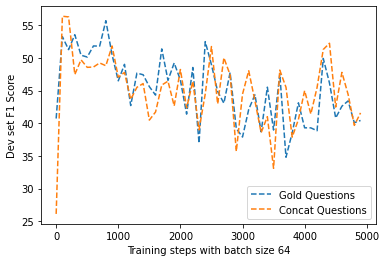

In [52]:
import numpy as np
import matplotlib.pyplot as plt

x = [i * 100 for i in range(0, 50, 1)]

plt.plot(x, fold_1_gold_f1s[:50], '--', label="Gold Questions")
plt.plot(x, fold_1_concat_f1s[:50], '--', label="Concat Questions")
#plt.plot(x, mml_mml_scores, 'p--', label="MML-MML Questions", color='green')
#plt.plot(x, length_10_mml_pgg_scores, '*--', label="MML-PGG Questions", color='red')
#plt.plot(x, length_10_mml_mml_answer_only_scores, 'o--', label="Answer Only", color='blue')
plt.legend()
plt.ylabel('Dev set F1 Score')
plt.xlabel('Training steps with batch size 64')
plt.show()